In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

# for i, data in enumerate(trainloader, 0):
#     print(len(data))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [17]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * ((Euv - Eu*Ev))
        self.beta = (1-eta)*self.beta + eta * (Ev)
        
        self.eta = eta * 0.996
        
        
class inc_BN(nn.Module):
    def __init__(self, layersize, eta=1):
        super(inc_BN, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * ((Euu - Eu**2))
        self.beta = (1-eta)*self.beta + eta * (Eu)
        
        self.eta = eta * 0.996
        
class og_IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(og_IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = self.alpha*x + self.beta
        
        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (1/self.alpha -2*Euv)
        self.beta = (1-eta)*self.beta + eta * -2*(Ev)
        
        self.eta = eta * 0.996


class Net(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(Net, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [19]:

def train_deep_model(network, optimization, seed):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(80):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 795

INPUTSIZE = 28*28
NBLAYERS = 9
LAYERSIZE = 50

int_lr = 0.2
syn_lr = 0.001

# #Train IP Model
# torch.manual_seed(seed)
# IPnet = Net()
# IPnet = IPnet.to(device)

# optimizer1 = optim.Adam(IPnet.parameters(), lr=0.001)
# print("Training IP Net")
# train_model(IPnet, optimizer1, seed, True)

# #Train Standard Model
# torch.manual_seed(seed)
# net = Net()
# net = net.to(device)

# optimizer2 = optim.Adam(net.parameters(), lr=0.001)
# print("Training Standard Net")
# train_model(net, optimizer2, seed, False)



#Train Deep Standard Model
torch.manual_seed(seed)
DSnet = DNet(LAYERSIZE, NN, eta=int_lr)
DSnet = DSnet.to(device)

optimizer = optim.Adam(DSnet.parameters(), lr=syn_lr)
print("Training Deep Standard Net")
standard_losses = train_deep_model(DSnet, optimizer, seed)



#Train Deep IP Model
torch.manual_seed(seed)
DIPnet = DNet(LAYERSIZE, IP, eta=int_lr)
DIPnet = DIPnet.to(device)

optimizer = optim.Adam(DIPnet.parameters(), lr=syn_lr)
print("IP with covariance and median")
ip_losses = train_deep_model(DIPnet, optimizer, seed)



#Train Deep OG IP
torch.manual_seed(seed)
DOGnet = DNet(LAYERSIZE, og_IP, eta=int_lr)
DOGnet = DOGnet.to(device)

optimizer = optim.Adam(DOGnet.parameters(), lr=syn_lr)
print("OG IP")
og_losses = train_deep_model(DOGnet, optimizer, seed)



#Train Deep Batch Norm Model
# torch.manual_seed(seed)
# Varnet = DNet(LAYERSIZE, inc_BN, eta=int_lr)
# Varnet = Varnet.to(device)

# optimizer = optim.Adam(Varnet.parameters(), lr=syn_lr)
# print("IP with variance and mean")
# var_losses = train_deep_model(Varnet, optimizer, seed)

# for param in IPnet.parameters():
#     print(param.data)
    
# for param in IPnet.parameters():
#     print(param.data)

# c_net = copy.deepcopy(net)

Training Deep Standard Net
[1,   100] loss: 1.770
[1,   200] loss: 0.847
[1,   300] loss: 0.530
[2,   100] loss: 0.419
[2,   200] loss: 0.366
[2,   300] loss: 0.344
[3,   100] loss: 0.288
[3,   200] loss: 0.252
[3,   300] loss: 0.233
[4,   100] loss: 0.194
[4,   200] loss: 0.188
[4,   300] loss: 0.190
[5,   100] loss: 0.158
[5,   200] loss: 0.152
[5,   300] loss: 0.157
[6,   100] loss: 0.129
[6,   200] loss: 0.144
[6,   300] loss: 0.131
[7,   100] loss: 0.116
[7,   200] loss: 0.115
[7,   300] loss: 0.126
[8,   100] loss: 0.105
[8,   200] loss: 0.104
[8,   300] loss: 0.105
[9,   100] loss: 0.094
[9,   200] loss: 0.102
[9,   300] loss: 0.093
[10,   100] loss: 0.083
[10,   200] loss: 0.085
[10,   300] loss: 0.097
[11,   100] loss: 0.085
[11,   200] loss: 0.077
[11,   300] loss: 0.083
[12,   100] loss: 0.075
[12,   200] loss: 0.078
[12,   300] loss: 0.070
[13,   100] loss: 0.066
[13,   200] loss: 0.069
[13,   300] loss: 0.069
[14,   100] loss: 0.066
[14,   200] loss: 0.065
[14,   300] loss

[34,   300] loss: 0.035
[35,   100] loss: 0.027
[35,   200] loss: 0.024
[35,   300] loss: 0.028
[36,   100] loss: 0.021
[36,   200] loss: 0.020
[36,   300] loss: 0.036
[37,   100] loss: 0.027
[37,   200] loss: 0.026
[37,   300] loss: 0.036
[38,   100] loss: 0.028
[38,   200] loss: 0.031
[38,   300] loss: 0.028
[39,   100] loss: 0.019
[39,   200] loss: 0.020
[39,   300] loss: 0.027
[40,   100] loss: 0.022
[40,   200] loss: 0.032
[40,   300] loss: 0.031
[41,   100] loss: 0.017
[41,   200] loss: 0.022
[41,   300] loss: 0.022
[42,   100] loss: 0.026
[42,   200] loss: 0.026
[42,   300] loss: 0.017
[43,   100] loss: 0.016
[43,   200] loss: 0.019
[43,   300] loss: 0.032
[44,   100] loss: 0.017
[44,   200] loss: 0.020
[44,   300] loss: 0.021
[45,   100] loss: 0.017
[45,   200] loss: 0.015
[45,   300] loss: 0.022
[46,   100] loss: 0.024
[46,   200] loss: 0.023
[46,   300] loss: 0.019
[47,   100] loss: 0.023
[47,   200] loss: 0.020
[47,   300] loss: 0.024
[48,   100] loss: 0.024
[48,   200] loss

[68,   300] loss: 0.030
[69,   100] loss: 0.022
[69,   200] loss: 0.019
[69,   300] loss: 0.032
[70,   100] loss: 0.020
[70,   200] loss: 0.027
[70,   300] loss: 0.027
[71,   100] loss: 0.024
[71,   200] loss: 0.020
[71,   300] loss: 0.023
[72,   100] loss: 0.022
[72,   200] loss: 0.022
[72,   300] loss: 0.026
[73,   100] loss: 0.020
[73,   200] loss: 0.022
[73,   300] loss: 0.022
[74,   100] loss: 0.022
[74,   200] loss: 0.028
[74,   300] loss: 0.021
[75,   100] loss: 0.015
[75,   200] loss: 0.019
[75,   300] loss: 0.027
[76,   100] loss: 0.025
[76,   200] loss: 0.020
[76,   300] loss: 0.020
[77,   100] loss: 0.017
[77,   200] loss: 0.017
[77,   300] loss: 0.023
[78,   100] loss: 0.019
[78,   200] loss: 0.014
[78,   300] loss: 0.023
[79,   100] loss: 0.025
[79,   200] loss: 0.023
[79,   300] loss: 0.020
[80,   100] loss: 0.018
[80,   200] loss: 0.029
[80,   300] loss: 0.021
Finished training!



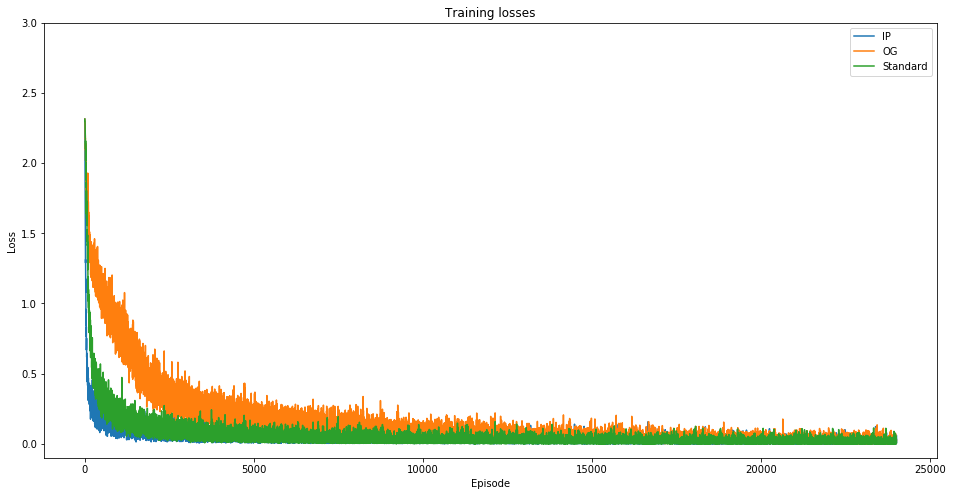

In [21]:
plt.figure(figsize=(16, 8))
plt.ylim([-0.1, 3])
plt.title("Training losses")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(var_losses[0], var_losses[1], label="Var")
plt.plot(og_losses[0], og_losses[1], label="OG")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y9  = DIPnet(images)
        _, predicted = torch.max(y9.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the IP network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y9  = Varnet(images)
        _, predicted = torch.max(y9.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the Var network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

# val1, ind1 = DIPnet.fc1.weight.max(0)
# max_weight = val1.max(0)
# print(max_weight)

# val1, ind1 = Dnet.fc1.weight.max(0)
# max_weight = val1.max(0)
# print(max_weight)

Accuracy of the IP network on the 10000 test images: 96.3700 %
Accuracy of the Var network on the 10000 test images: 96.2300 %
